Copyright © 2025 Technical University of Denmark
# Comparing the simulation of a random GBS circuit with bosonicplus and strawberryfield's Fock backend

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from lcg_plus.operations.circuit_parameters import gen_interferometer_params
from lcg_plus.operations.gbs import build_interferometer
from lcg_plus.base import State
from lcg_plus.fidelity import overlap_log
from lcg_plus.plotting import plot_wig
from time import time

## Simulate GBS circuit with bosonicplus

In [2]:
num = 3 #Number of modes
n = 4
ns = np.repeat(n, num-1) #Photon pattern
np.random.seed(13) #Seed for random circuit parameters

ti = time()
params = gen_interferometer_params(num, -6)

print('Building the interferometer')
print('-'*50)
state_coherent = build_interferometer(params, num, out = True)
eta = 1
state_coherent.apply_loss(np.repeat(eta, num), np.zeros(num))

t1 = time()
print(f'Circuit building time = {t1-ti} s')

print('\nPerforming photon measurements')
print('-'*50)

T0 = time()

for i, n in enumerate(ns):
    
    t0 = time()
    
    modes = np.arange(state_coherent.num_modes)

    state_coherent.post_select_fock_coherent(modes[-1], n, inf=1e-6, out=True )
    
    t1 = time()
    print(f'Post selection time {t1-t0} s')

T1 = time()

print(f'Total time for measurements {T1-T0} s')

print(f'\nTotal simulation time {T1-ti} s')

print('Heralding probability', state_coherent.norm)

Building the interferometer
--------------------------------------------------
Sgate[0.384,0.000] on mode 0
Sgate[-0.363,0.000] on mode 1
Sgate[0.448,0.000] on mode 2
BSgate[1.424,0.000] on modes 0 and 1
BSgate[1.433,0.000] on modes 1 and 2
BSgate[0.722,0.000] on modes 0 and 1
Circuit building time = 0.0016279220581054688 s

Performing photon measurements
--------------------------------------------------
Measuring 4 photons in mode 2.
Data shape before measurement, [(1, 6), (1, 6, 6)].
Probability of measurement = 5.134e-03
Data shape after measurement, [(15, 4), (1, 4, 4)]
Post selection time 0.0016629695892333984 s
Measuring 4 photons in mode 1.
Data shape before measurement, [(15, 4), (1, 4, 4)].
Probability of measurement = 4.559e-06
Data shape after measurement, [(325, 2), (1, 2, 2)]
Post selection time 0.0006589889526367188 s
Total time for measurements 0.0024788379669189453 s

Total simulation time 0.004214763641357422 s
Heralding probability 4.558832809231712e-06


## Simulate the circuit in strawberryfields Fock basis

In [3]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, MeasureFock, MeasureHomodyne, LossChannel
from thewalrus.quantum import state_vector, density_matrix

In [4]:
#Get the heralding probability

sqz = params['sqz']
bs = params['bs']

eng = sf.Engine('gaussian')
prog = sf.Program(num)

ns_fock = ns.tolist()

t0 = time()

with prog.context as q:
    for i in range(num):
        Sgate(sqz[i][0], sqz[i][1]) | q[i]
    for i in range(len(bs)):
        BSgate(bs[i][0], bs[i][1]) | (q[bs[i][2][0]], q[bs[i][2][1]])
    

result = eng.run(prog)
state = result.state
tf = time()


mu, cov = state.means(), state.cov()

cutoff = 50
psi = state_vector(mu, cov, post_select={1:n, 2: n}, normalize=False, cutoff=cutoff)
p_psi = np.linalg.norm(psi)
psi = psi / p_psi
print('The probability of successful heralding is {:.10f}.'.format(p_psi ** 2))

The probability of successful heralding is 0.0000045588.


/Users/s163967/venv/240229-olgacvsim/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
/Users/s163967/venv/240229-olgacvsim/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det


In [5]:
#Get the output state

sqz = params['sqz']
bs = params['bs']

eng = sf.Engine('fock', backend_options={"cutoff_dim": 14})

prog = sf.Program(num)

ns_fock = ns.tolist()

t0 = time()

with prog.context as q:
    for i in range(num):
        Sgate(sqz[i][0], sqz[i][1]) | q[i]
    for i in range(len(bs)):
        BSgate(bs[i][0], bs[i][1]) | (q[bs[i][2][0]], q[bs[i][2][1]])
    for i in range(num):
        LossChannel(eta) | q[i]
    
    
        
    for i in range(num-1):
        MeasureFock(select = ns_fock[i]) | q[(num-1)-i] #Measure the last mode

result = eng.run(prog)
tf = time()

print(f'Total simulation time {tf-t0}')

Total simulation time 7.824098110198975


## Comparing the output state from both methods
Increasing the `cutoff_dim` in `backend_options` in `eng` will improve strawberryfield's accuracy.

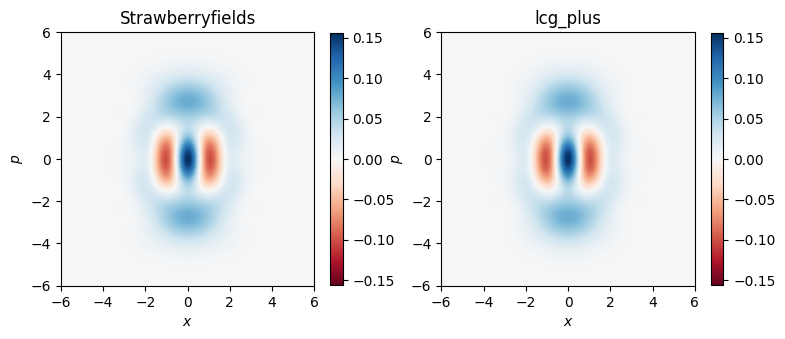

Fidelity to vacuum sf:  0.1516262294139556
Fidelity to vacuum lcg_plus:  (0.1516394001354333-4475872945.510709j)


In [7]:
state = result.state

x = np.linspace(-6,6,100)
W = state.wigner(0,x,x)
fig, axes = plt.subplots(1,2, figsize = (9,4))
plot_wig(W,x,x, ax = axes[0])
axes[0].set_title(f'Strawberryfields')
W_coherent = state_coherent.get_wigner_log(x,x)
plot_wig(W_coherent.real, x, x, ax = axes[1])
axes[1].set_title(f'lcg_plus')

plt.show()


print('Fidelity to vacuum sf: ', state.fidelity_vacuum() )
print('Fidelity to vacuum lcg_plus: ', overlap_log(state_coherent, State()))

## Post selecting on psuedo PNRD measurement outcome with bosonicplus
This method will run into precision issues the higher the number of on/off detectors per click detector `M` for the same reason that the bosonicbackend's Fock approximation runs into precision issues. 

In [8]:
M = 10 #Number of on/off detectors per pPNRD
ti = time()

print('Building the interferometer')
print('-'*50)
state_th = build_interferometer(params, num, out=True)
t1 = time()
print(f'Circuit building time = {t1-ti} s')

print('\nPerforming click measurements')
print('-'*50)

T0 = time()

for i, n in enumerate(ns):
    
    t0 = time()
    modes = np.arange(state_th.num_modes)
    state_th.post_select_ppnrd_thermal(modes[-1], n, M, out=True)
    t1 = time()
    print(f'Post selection time {t1-t0} s')

T1 = time()

print(f'Total time for measurements {T1-T0} s')

print(f'\nTotal simulation time {T1-ti} s')
print('Heralding probability', state_th.norm)

Building the interferometer
--------------------------------------------------
Sgate[0.384,0.000] on mode 0
Sgate[-0.363,0.000] on mode 1
Sgate[0.448,0.000] on mode 2
BSgate[1.424,0.000] on modes 0 and 1
BSgate[1.433,0.000] on modes 1 and 2
BSgate[0.722,0.000] on modes 0 and 1
Circuit building time = 0.00151824951171875 s

Performing click measurements
--------------------------------------------------
Measuring 4 clicks in mode 2.
Data shape before measurement, [(1, 6), (1, 6, 6)].
Probability of measurement = 2.925e-03+1.913e-13j
Data shape after measurement, [(5, 4), (5, 4, 4)]
Post selection time 0.0011670589447021484 s
Measuring 4 clicks in mode 1.
Data shape before measurement, [(5, 4), (5, 4, 4)].
Probability of measurement = 1.888e-06
Data shape after measurement, [(25, 2), (25, 2, 2)]
Post selection time 0.0008130073547363281 s
Total time for measurements 0.0022847652435302734 s

Total simulation time 0.003994941711425781 s
Heralding probability 1.8882665385126336e-06


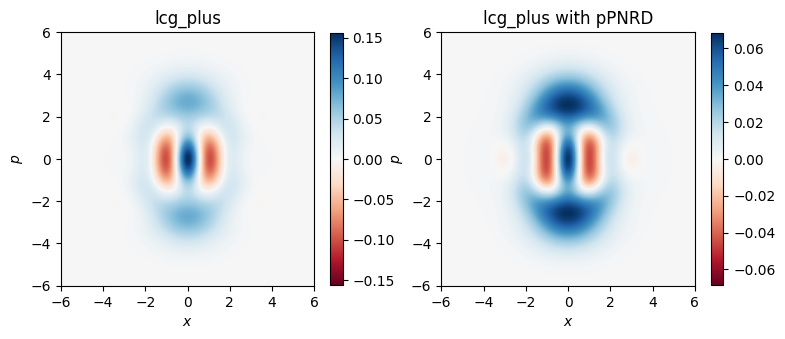

In [9]:
fig, axes = plt.subplots(1,2, figsize = (9,4))
plot_wig(W_coherent.real, x, x, ax = axes[0])

axes[0].set_title(f'lcg_plus')

#state_th = get_state(circuit)
W = state_th.get_wigner_bosonic(x,x)

plot_wig(W.real, x, x, ax = axes[1])
axes[1].set_title(f'lcg_plus with pPNRD')

plt.show()